In [1]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from matplotlib.lines import Line2D
import matplotlib
import warnings
import os
from data_cleaning import (
    calculate_indicator_summary, 
    summarize_data_wide, 
    input_missing_data, 
    standardize)
from homology import (
    safe_linspace,
    stable_rank,
    betti_curve,
    safe_interp
)

In [2]:
# ------------------------------
# 1. Load data
# ------------------------------
data_dir = "C:/Users/padil/Documents/TDA/DATA/"

data_countries = pd.read_csv(os.path.join(data_dir, "Data_countries_blind.csv")) # Data for countries
data_regions = pd.read_csv(os.path.join(data_dir, "Data_regions_blind.csv")) # Data for regions
world_regions_latest = pd.read_csv(os.path.join(data_dir,"clean_world_regions.csv")) # Map of countries into regions
happiness_raw = pd.read_csv(os.path.join(data_dir,"Happiness_data.csv"), encoding='latin-1') 
democracy_raw = pd.read_csv(os.path.join(data_dir,"democracy-index-eiu.csv"), ) 

In [3]:
happiness = happiness_raw[['Year', 'Country name', 'Life evaluation (3-year average)']].loc[happiness_raw['Country name'].notna() & (happiness_raw['Year'] == 2024.0)]
happiness['Happiness'] = pd.cut(x=happiness['Life evaluation (3-year average)'], bins=[0, 4, 6, 8],
                     labels=[0,1,2])

In [4]:
democracy = democracy_raw.loc[democracy_raw['Code'].notna() & (democracy_raw['Year'] == 2024.0)].copy()
democracy['Democracy'] = pd.cut(x=democracy['Democracy index'], bins=[0, 6, 10],
                     labels=[0,1])
democracy['Democracy label'] = pd.cut(x=democracy['Democracy index'], bins=[0, 4, 6, 8, 10],
                     labels=["full democracy", "flawed democracy", "hybrid regime", "authoritarian regime"])

In [24]:
import pandas as pd
from typing import Tuple, Dict

def filter_indicators_by_nan_rate(
    df: pd.DataFrame, 
    min_valid_country_ratio: float = 0.6
) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """
    Filters out indicators (Series Code) with too many NaNs across countries,
    and returns both the filtered DataFrame and a dict of kept indicators.

    Keeps only indicators where at least `min_valid_country_ratio` of countries
    have at least one non-NaN value among the year columns.

    Args:
        df: WDI-style DataFrame with columns like 
             ['Country Name', 'Country Code', 'Series Name', 'Series Code', <year columns>].
        min_valid_country_ratio: Minimum fraction of countries that must have
                                 at least one valid data point for an indicator.

    Returns:
        (filtered_df, kept_indicators)
        - filtered_df: The subset of df containing only valid indicators.
        - kept_indicators: dict mapping Series Code → Series Name.
    """
    # Identify year columns (assumed to start at 5th column)
    year_cols = df.columns[4:]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate coverage: for each indicator, count countries with any non-NaN value
    valid_counts = (
        df.groupby('Series Code')[year_cols]
        .apply(lambda x: x.notna().any(axis=1).sum())
    )

    total_counts = df.groupby('Series Code')['Country Name'].nunique()
    valid_ratio = valid_counts / total_counts

    # Keep indicators above threshold
    valid_indicators = valid_ratio[valid_ratio >= min_valid_country_ratio].index

    filtered_df = df[df['Series Code'].isin(valid_indicators)].copy()

    # Build indicator dictionary
    kept_indicators = (
        filtered_df[['Series Code', 'Series Name']]
        .drop_duplicates()
        .set_index('Series Code')['Series Name']
        .to_dict()
    )

    country_nans = df.groupby('Country Name')['Series Code'].nunique()
    print(f"Kept {len(kept_indicators)} of {df['Series Code'].nunique()} indicators "
          f"({len(kept_indicators)/df['Series Code'].nunique():.1%}) "
          f"with ≥{min_valid_country_ratio:.0%} valid-country coverage.",
          country_nans)

    return filtered_df, kept_indicators

In [6]:
# ------------------------------
# 2. Mappings
# ------------------------------
indicators = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth',
    'SP.DYN.LE00.IN': 'life_expectancy',
    'SP.DYN.IMRT.IN': 'infant_mortality',
    'SE.SEC.ENRR': 'school_enrollment',
    #'SE.ADT.LITR.ZS': 'literacy_rate',
    'SH.XPD.CHEX.GD.ZS': 'health_spending',
    #'SI.POV.GINI': 'gini',
    'SI.POV.DDAY': 'poverty',
    'SP.POP.GROW': 'pop_growth',
    'EG.ELC.ACCS.ZS': 'electricity_access',
    'SM.POP.NETM': 'migration',
    'NV.AGR.TOTL.ZS': 'agriculture_weight_GDP',
    'SE.XPD.TOTL.GD.ZS': 'education spending'
}

wb_region_map = {
    "Latin America and Caribbean (WB)": "Latin America & Caribbean",
    "Sub-Saharan Africa (WB)": "Sub-Saharan Africa",
    "East Asia and Pacific (WB)": "East Asia & Pacific",
    "Europe and Central Asia (WB)": "Europe & Central Asia",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)": "Middle East, North Africa, Afghanistan & Pakistan",
    "South Asia (WB)": "South Asia",
    "North America (WB)": "North America"
}

In [25]:
df, indicators = filter_indicators_by_nan_rate(data_regions, 1.0)

Kept 262 of 574 indicators (45.6%) with ≥100% valid-country coverage. Country Name
Data from database: World Development Indicators       0
East Asia & Pacific                                  574
Europe & Central Asia                                574
Last Updated: 10/07/2025                               0
Latin America & Caribbean                            574
Middle East, North Africa, Afghanistan & Pakistan    574
North America                                        574
South Asia                                           574
Sub-Saharan Africa                                   574
Name: Series Code, dtype: int64


In [8]:
# ------------------------------
# 3. Build data matrix by filling empty indicators and dropping non-filled enough countries
# ------------------------------
calculations = ['median']

# Country level data
data_wide = summarize_data_wide(data_countries, indicators, calculations)

country_region_map = world_regions_latest.set_index('Code')['World regions according to WB'].map(wb_region_map).to_dict()
data_wide['region'] = data_wide['Country Code'].map(country_region_map)

# Region level data
data_region_wide = summarize_data_wide(data_regions, indicators, calculations)
data_region_wide = data_region_wide.rename(columns={'Country Name': 'region'})

data_wide_full = input_missing_data(data_wide, data_region_wide)

if 'gdp_per_capita' in data_wide_full.columns: # Log-transform GDP per capita safely
    data_wide_full['gdp_per_capita'] = data_wide_full['gdp_per_capita'].apply(lambda x: np.log10(x) if x>0 else np.nan)

X, countries, regions = standardize(data_wide_full)


In [9]:
happiness_scores = happiness[['Country name', 'Happiness']]

happiness_data = data_wide_full.merge(
    happiness_scores,
    left_on='Country Name',  # Column from data_wide_full
    right_on='Country name', # Column from happiness_scores
    how='inner'
)
label_happ = happiness_data['Happiness'].values
happiness_data = happiness_data.drop(columns=['Country name', 'Happiness'])

X_happ, countries, regions = standardize(happiness_data)

In [10]:
democracy_scores = democracy[['Code', 'Democracy']]

democracy_data = data_wide_full.merge(
    democracy_scores,
    left_on='Country Code',  # Column from data_wide_full
    right_on='Code', # Column from happiness_scores
    how='inner'
)
label_dem = democracy_data['Democracy'].values
democracy_data = democracy_data.drop(columns=['Code', 'Democracy'])

X_dem, countries, regions = standardize(democracy_data)

In [11]:
analysis_type = 2
if analysis_type==0:
    X_data = X
elif analysis_type==0:
    X_data = X_happ
else:
    X_data = X_dem

[[ 0.         31.08872794 26.21440925 ... 19.60694505 22.87052077
  22.63385721]
 [31.08872794  0.         15.24264483 ... 25.81095337 22.96211891
  25.0348587 ]
 [26.21440925 15.24264483  0.         ... 20.03219681 20.37450251
  23.00324434]
 ...
 [19.60694505 25.81095337 20.03219681 ...  0.         18.16531733
  19.91751852]
 [22.87052077 22.96211891 20.37450251 ... 18.16531733  0.
  11.62511931]
 [22.63385721 25.0348587  23.00324434 ... 19.91751852 11.62511931
   0.        ]]


(array([ 1.,  1., 24., 47., 43., 29., 14.,  1.,  4.,  2.]),
 array([ 0.        ,  3.90450253,  7.80900506, 11.71350759, 15.61801012,
        19.52251265, 23.42701518, 27.33151771, 31.23602024, 35.14052277,
        39.0450253 ]),
 <BarContainer object of 10 artists>)

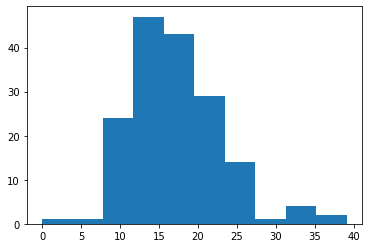

In [12]:
dist_matrix = squareform(pdist(X_data, metric='euclidean'))
print(dist_matrix)
plt.hist(dist_matrix[100])

Processing distribution: 0_20


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 10_30


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 20_40


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 30_50


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 40_60


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

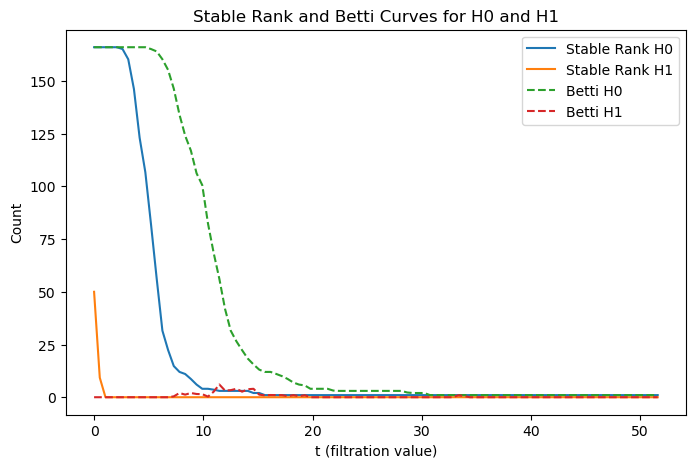

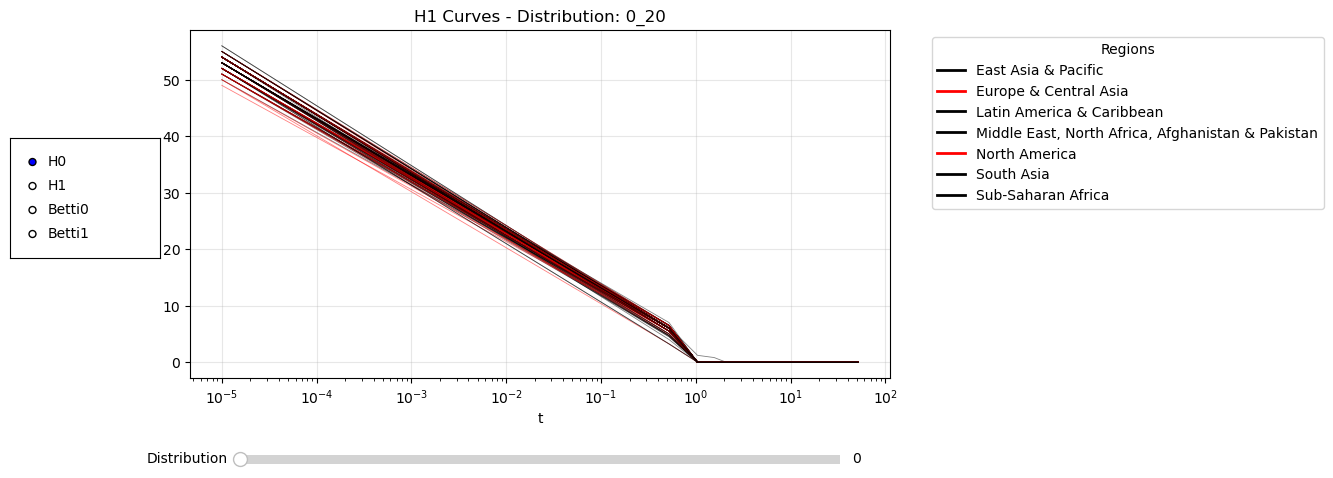

In [13]:
unique_regions = sorted(set(regions))
cmap = matplotlib.colormaps.get_cmap("tab10").resampled(len(unique_regions))
region_colors = {region: cmap(i) for i, region in enumerate(unique_regions)}

hemisphere_colors = {}
for region in unique_regions:
    if region in ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]:
        hemisphere_colors[region] = "black"
    elif region in ["Europe & Central Asia", "North America"]:
        hemisphere_colors[region] = "red"
    elif region in ["authoritarian regime", "hybrid regime"]:
        hemisphere_colors[region] = "black"
    elif region in ["flawed democracy","full democracy"]:
        hemisphere_colors[region] = "red"
    else:
        # fallback (optional)
        hemisphere_colors[region] = "gray"

metrics = ["euclidean"] # , "hamming", "mahalanobis"
for metric in metrics:
    dist_matrix = squareform(pdist(X_data, metric=metric))

    rips = ripser(dist_matrix, maxdim=1, distance_matrix=True)
    plt.figure()
    plot_diagrams(rips['dgms'], show=False, title="Persistence Diagrams")
    #plt.savefig(f"Persistence_{metric}.pdf", bbox_inches='tight')
    plt.close()

    homology_results = {}

    for dim, label in enumerate(["H0", "H1"]):
        diagram = rips["dgms"][dim]
        t_vals = safe_linspace(diagram, num=100, default_max=np.max(dist_matrix))

        # Stable Rank and Betti
        sr = stable_rank(diagram, t_vals, include_infinite=True)
        betti = betti_curve(diagram, t_vals)

        # Interpolate to a common t-grid (for comparison)
        t_uniform = np.linspace(0, np.max(dist_matrix), 100)
        sr_interp = safe_interp(t_uniform, t_vals, sr)
        betti_interp = safe_interp(t_uniform, t_vals, betti)

        homology_results[label] = {
            "diagram": diagram,
            "t_vals": t_vals,
            "sr": sr,
            "betti": betti,
            "t_uniform": t_uniform,
            "sr_uniform": sr_interp,
            "betti_uniform": betti_interp,
        }

    sr_H0 = homology_results["H0"]["sr_uniform"]
    betti_H0 = homology_results["H0"]["betti_uniform"]
    sr_H1 = homology_results["H1"]["sr_uniform"]
    betti_H1 = homology_results["H1"]["betti_uniform"]
    t_vals = homology_results["H0"]["t_uniform"]

    # Sampling
    number_data_points = X_data.shape[0]

    def uniform_distribution_interval(low, high):
        def f(distances):
            prob = np.clip((distances - low) / (high - low), 0, 1)
            if prob.sum() == 0:
                return np.ones_like(prob) / len(prob)
            return prob / prob.sum()
        return f

    distributions = {
        # "0_50": uniform_distribution_interval(0, 50),
        # "25_75": uniform_distribution_interval(25, 75),
        # "50_100": uniform_distribution_interval(50, 100),
        # "75_125": uniform_distribution_interval(75, 125),
        # "100_150": uniform_distribution_interval(100, 150),
        # "125_175": uniform_distribution_interval(125, 175),
        # "150_200": uniform_distribution_interval(150, 200),

        "0_20": uniform_distribution_interval(0, 20),
        "10_30": uniform_distribution_interval(10, 30),
        "20_40": uniform_distribution_interval(20, 40),
        "30_50": uniform_distribution_interval(30, 50),
        "40_60": uniform_distribution_interval(40, 60),
    }

    number_instances = 100    # number of random samples per base point
    sample_size = 10          # number of points in each sample
    t_len = 100               # number of t-values
    t_global = np.linspace(0, np.max(dist_matrix), t_len)  # common t-grid

    sr_H0_samp, sr_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}
    betti_H0_samp, betti_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}

    # --- Main sampling loop ---
    for k, dist_func in distributions.items():
        print(f"Processing distribution: {k}")
        for i in range(number_data_points):
            p = dist_func(dist_matrix[i])

            # Generate multiple random subsets
            sampled_indices = []
            for _ in range(number_instances):
                sampled_indices.append(np.random.choice(number_data_points, size=sample_size, p=p))
            sampled_indices = np.unique(np.concatenate(sampled_indices))

            # Skip trivial subsets
            if len(sampled_indices) < 2:
                sr_H0_samp[k].append(np.zeros(t_len))
                sr_H1_samp[k].append(np.zeros(t_len))
                betti_H0_samp[k].append(np.zeros(t_len))
                betti_H1_samp[k].append(np.zeros(t_len))
                continue

            X_subset = X[sampled_indices]
            rips = ripser(X_subset, maxdim=1)
            H0_dgm, H1_dgm = rips['dgms']

            # H0 computations
            t_local_H0 = safe_linspace(H0_dgm, t_len, default_max=np.max(dist_matrix))
            sr0 = stable_rank(H0_dgm, t_local_H0)
            betti0 = betti_curve(H0_dgm, t_local_H0)
            sr_H0_samp[k].append(safe_interp(t_global, t_local_H0, sr0))
            betti_H0_samp[k].append(safe_interp(t_global, t_local_H0, betti0))

            # H1 computations
            t_local_H1 = safe_linspace(H1_dgm, t_len, default_max=np.max(dist_matrix))
            sr1 = stable_rank(H1_dgm, t_local_H1)
            betti1 = betti_curve(H1_dgm, t_local_H1)
            sr_H1_samp[k].append(safe_interp(t_global, t_local_H1, sr1))
            betti_H1_samp[k].append(safe_interp(t_global, t_local_H1, betti1))

    plt.figure(figsize=(8, 5))
    plt.plot(t_vals, sr_H0, label="Stable Rank H0")
    plt.plot(t_vals, sr_H1, label="Stable Rank H1")
    plt.plot(t_vals, betti_H0, '--', label="Betti H0")
    plt.plot(t_vals, betti_H1, '--', label="Betti H1")
    plt.xlabel("t (filtration value)")
    plt.ylabel("Count")
    plt.title("Stable Rank and Betti Curves for H0 and H1")
    plt.legend()
    plt.show()


    # --- Distributions ---
    distribution_names = list(distributions.keys())
    n_distributions = len(distribution_names)
    number_samples = len(regions)

    # --- Homology / curves dictionaries ---
    homology_types = {
        'H0': sr_H0_samp,
        'H1': sr_H1_samp,
        'Betti0': betti_H0_samp,
        'Betti1': betti_H1_samp
    }
    homology_labels = ['H0', 'H1', 'Betti0', 'Betti1']

    # --- Initial settings ---
    current_homology = 'H1'
    current_distribution = 0  # index into distribution_names

    # --- Handle t=0 for log scale ---
    epsilon = 1e-5
    t_plot = np.maximum(t_global, epsilon)

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.subplots_adjust(bottom=0.3, left=0.2)
    ax.set_xscale('log')  # log scale
    ax.set_xlabel("t")
    ax.set_ylabel(current_homology)
    ax.grid(alpha=0.3)

    # --- Initial plot lines ---
    lines = []
    for i in range(number_samples):
        region = regions[i]
        curve_dict = homology_types[current_homology]
        curve = curve_dict[distribution_names[current_distribution]][i]
        #line, = ax.plot(t_plot, curve, color=region_colors[region], alpha=0.5, lw=0.6)
        line, = ax.plot(t_plot, curve, color=hemisphere_colors[region], alpha=0.5, lw=0.6)
        lines.append(line)

    ax.set_title(f"{current_homology} Curves - Distribution: {distribution_names[current_distribution]}")

    # --- Slider for distributions ---
    ax_slider = plt.axes([0.25, 0.15, 0.6, 0.03])
    slider = Slider(ax_slider, 'Distribution', 0, n_distributions-1,
                    valinit=current_distribution, valstep=1, valfmt='%0.0f')

    # --- Radio buttons for homology type ---
    ax_radio_hom = plt.axes([0.02, 0.5, 0.15, 0.2])
    radio_hom = RadioButtons(ax_radio_hom, homology_labels)

    # --- Update functions ---
    def update_slider(val):
        idx = int(slider.val)
        dist_name = distribution_names[idx]
        for i in range(number_samples):
            region = regions[i]
            curve_dict = homology_types[current_homology]
            lines[i].set_ydata(curve_dict[dist_name][i])
            #lines[i].set_color(region_colors[region])
            lines[i].set_color(hemisphere_colors[region])
        ax.set_title(f"{current_homology} Curves - Distribution: {dist_name}")
        fig.canvas.draw_idle()

    max_t_H0 = np.max([np.max(curve) for k in distributions.keys() for curve in sr_H0_samp[k]])
    max_t_H1 = np.max([np.max(curve) for k in distributions.keys() for curve in sr_H1_samp[k]])

    def update_homology(label):
        global current_homology
        current_homology = label
        ax.set_ylabel(current_homology)
        
        # --- x-axis scale ---
        if current_homology in ['H1', 'Betti1']:
            ax.set_xscale('log')
            ax.set_xlim(np.min(t_plot), np.max(t_plot))  # use t_plot for log
        else:
            ax.set_xscale('linear')
            if current_homology in ['H0']:
                ax.set_xlim(0, 1.5)
            elif current_homology in ['Betti0']:
                ax.set_xlim(0, 2.5)
            else:
                ax.set_xlim(0, np.max(t_global))
        
        # --- y-axis scaling ---
        if current_homology in ['H0', 'Betti0']:
            ax.set_ylim(0, np.max([np.max(sr_H0_samp[k][current_distribution]) for k in distributions]))
        else:  # H1 or Betti1
            ax.set_ylim(0, np.max([np.max(sr_H1_samp[k][current_distribution]) for k in distributions]))
        
        update_slider(slider.val)

    slider.on_changed(update_slider)
    radio_hom.on_clicked(update_homology)

    # --- Legend for regions ---
    #legend_elements = [Line2D([0],[0], color=region_colors[r], lw=2, label=r) for r in unique_regions]
    legend_elements = [Line2D([0],[0], color=hemisphere_colors[r], lw=2, label=r) for r in unique_regions]
    ax.legend(handles=legend_elements, title="Regions", bbox_to_anchor=(1.05,1), loc='upper left')

    plt.show()
    



# Classif

In [14]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from datetime import timedelta


In [15]:
region = data_wide['region']
south = ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]
label_region = region.apply(lambda x: 1 if x in south else 0).values

In [16]:
if analysis_type == 0:
    data = data_wide_full.copy()
    label = label_region
elif analysis_type==1:
    data = democracy_data.copy()
    label = label_dem
else:
    data = happiness_data.copy()
    label = label_happ

X_train, X_test, y_train, y_test = train_test_split(np.arange(len(data)), 
                                                    label, 
                                                    test_size=0.5)

In [17]:
train = [X_data[i] for i in X_train]
test = [X_data[i] for i in  X_test]

start = timer()    

kernel_train = np.asarray([[np.dot(f,g) for g in train] for f in train])
kernel_test = np.asarray([[np.dot(f,g) for g in train] for f in test])

end = timer()
print(timedelta(seconds=end-start))

0:00:00.017431


In [18]:
clf = svm.SVC(kernel='precomputed')
clf.fit(kernel_train, y_train)
prediction = clf.predict(kernel_test )
a_score = accuracy_score(y_test, prediction)
print("classification accuracy: ", a_score)

classification accuracy:  0.4657534246575342


In [19]:
h0_kernel_train = {}
h0_kernel_test = {}
h0_prediction = {}
h0_a_score = {}
start = timer()  

for k in distributions.keys():
    h0_train = [sr_H0_samp[k][i] for i in X_train]
    h0_test = [sr_H0_samp[k][i] for i in X_test]
    kernel_train = np.asarray([[f.dot(g) for g in h0_train] for f in h0_train])
    kernel_test = np.asarray([[f.dot(g) for g in h0_train] for f in h0_test])
    h0_kernel_train[k] = kernel_train
    h0_kernel_test[k] = kernel_test
    clf = svm.SVC(kernel='precomputed')
    clf.fit(kernel_train, y_train)
    pred = clf.predict(kernel_test )
    h0_prediction[k] = pred
    h0_a_score[k] = accuracy_score(y_test, pred)
    print(k)
end = timer()
print("h0 pred: ", timedelta(seconds=end-start))

h1_kernel_train = {}
h1_kernel_test = {}
h1_prediction = {}
h1_a_score = {}

start = timer()  

for k in distributions.keys():
    h1_train = [sr_H1_samp[k][i] for i in X_train]
    h1_test = [sr_H1_samp[k][i] for i in X_test]
    kernel_train = np.asarray([[f.dot(g) for g in h1_train] for f in h1_train])
    kernel_test = np.asarray([[f.dot(g) for g in h1_train] for f in h1_test])
    h1_kernel_train[k] = kernel_train
    h1_kernel_test[k] = kernel_test
    clf = svm.SVC(kernel='precomputed')
    clf.fit(kernel_train, y_train)
    pred = clf.predict(kernel_test )
    h1_prediction[k] = pred
    h1_a_score[k] = accuracy_score(y_test, pred)
    print(k)
end = timer()
print("h1 pred: ", timedelta(seconds=end-start))

0_20
10_30
20_40
30_50
40_60
h0 pred:  0:00:00.235348
0_20
10_30
20_40
30_50
40_60
h1 pred:  0:00:00.043913


In [20]:
for k in h0_a_score.keys():
    print("distribution "+k+", h0 score:", round(h0_a_score[k],2), 
          ", h1 score:", round(h1_a_score[k],2))

distribution 0_20, h0 score: 0.4 , h1 score: 0.48
distribution 10_30, h0 score: 0.42 , h1 score: 0.42
distribution 20_40, h0 score: 0.42 , h1 score: 0.45
distribution 30_50, h0 score: 0.42 , h1 score: 0.49
distribution 40_60, h0 score: 0.41 , h1 score: 0.45


In [21]:
y_test[0]

np.int64(2)

In [22]:
h0_wrong_class = {}
for k in  distributions.keys():
    h0_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h0_prediction[k])):
        v = y_test[i]
        p = h0_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h0_wrong_class[k]["index"] = indx
        h0_wrong_class[k]["value"] = values
        h0_wrong_class[k]["prediction"] = pred

h1_wrong_class = {}
for k in  distributions.keys():
    h1_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h1_prediction[k])):
        v = y_test[i]
        p = h1_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h1_wrong_class[k]["index"] = indx
        h1_wrong_class[k]["value"] = values
        h1_wrong_class[k]["prediction"] = pred

In [23]:
print(h1_wrong_class["0_4"]['index'])
data_wide['Country Name'].iloc[h1_wrong_class["0_4"]['index']]


KeyError: '0_4'